# Robust Analysis of rtgM4

In [5]:
using Pkg
Pkg.activate("RobustAnalysis")

  Activating environment at `~/project/MitoRetrogradeModel/MitoChannelAnalysis/RobustAnalysis/Project.toml`


In [6]:
Pkg.instantiate();

In [57]:
using RetroSignalModel 
using SteadyStateDiffEq
using StochasticDiffEq
using DiffEqNoiseProcess
using OrdinaryDiffEq
using ModelingToolkit
using Catalyst
using Parameters
using ProgressBars
using InformationMeasures
using KernelDensity
using QuadGK
using Random
using DiffEqCallbacks
using CSV
using DataFrames
using Folds
import JLD as j
import PyPlot as plt

plt.rc("font", family="sans", size="15")

In [8]:
df = CSV.read("SteadyStates/data/valid_ss.csv", DataFrame);

In [9]:
function get_rn_name(rn::ReactionSystem, df, u_, p_; i= 1, input_var_name = :s)
    u = deepcopy(u_)
    p1 = deepcopy(p_)
    for (j,var) in enumerate( string.(species(rn)))
        var_name = var[1:end-3] # remove '(t)' 
        u[j] = df[i, var_name]
    end
        
    p1[1] = df[i,input_var_name]
    return u, p1 
end

get_rn_name (generic function with 1 method)

## Define Problem 

|Input|Output|
|---|---|
|$s$|$Total_{Rtg13_{n}}$|

In [10]:
#Objective function
function output(us, inds)
    return [ sum(u[inds]) for u in us]
end


rtg13_n = [11,12,15,16]

# get total concentration of rtg3 
rn = RetroSignalModel.rtgM4.NoInputModel
u_ = collect(RetroSignalModel.rtgM4.param_NoInputModel().u)
p_ = collect(RetroSignalModel.rtgM4.param_NoInputModel().p)

pr_is = RetroSignalModel.get_protein_lookup(rn)
rtg3_total = sum(u_[pr_is[:Rtg3]])

409.50361198830126

In [11]:
# Plotting function 
function save(FIG , fn)
    FIG.savefig(fn, transparent=true, bbox_inches = "tight" )
end

function plotcurve!(ax, arr, scale)
    ax.plot(range(0,1,length=size(heatmap)[1]),arr/scale, "r", linestyle="--", label="Steady State (ODE)")
end

plotcurve! (generic function with 1 method)

## Callback function for maintaining of Chemical Langevin Function 

Use callback technique to flip negative value to positive when the concentration is too small.

In [12]:
function condition(u,p, integrator) 
   any(x -> x < 0, u)
end 


function affect!(integrator)
    neg_is = findall(x-> x<0., integrator.u)
    for i in neg_is 
        integrator.u[i] = -integrator.u[i]
    end
end


cb = DiscreteCallback(condition,affect!)

DiscreteCallback{typeof(condition), typeof(affect!), typeof(DiffEqBase.INITIALIZE_DEFAULT), typeof(DiffEqBase.FINALIZE_DEFAULT)}(condition, affect!, DiffEqBase.INITIALIZE_DEFAULT, DiffEqBase.FINALIZE_DEFAULT, Bool[1, 1])

## Set up noise and input domain

In [33]:
## Get HeatMap
noise = 0.00001 # 1e-5
tspan = (0.,100.)
out = []
IN  = []
s = 0.:0.001:1.

savename = "RobustAnalysis/result/SDE_1em$(-1*Int(log10(noise)))_t1000.jld"

"RobustAnalysis/result/SDE_1em5_t1000.jld"

## Solving SDE 

Derive the kernel density functions in the screen of input

In [14]:
# @time 15 minutes (single core)
function solve_ss(rn,u,p,s; solver=DynamicSS(AutoTsit5(Rosenbrock23())))    
    solss = let # Steady State Solution
        function prob_func(prob,i,repeat)
            remake(prob;p= [s[i], p[2:end]...])
        end

        function output_func(sol,i)
           return (sol.u, false) 
        end

        prob = SteadyStateProblem(rn, u, p)
        ensemble_prob = EnsembleProblem(prob, prob_func=prob_func, output_func = output_func)

        solss = solve(ensemble_prob, solver, EnsembleThreads(); trajectories=length(s))
    end;
end

solve_ss (generic function with 1 method)

In [15]:
solss = solve_ss(rn, u_, p_, s)

@show "Time usage: $(solss.elapsedTime) seconds"

"Time usage: $(solss.elapsedTime) seconds" = "Time usage: 38.798847891 seconds"


"Time usage: 38.798847891 seconds"

In [ ]:
u_sdes = zeros(length(s), length(u_))

kdes = let # Kernel Density
    function prob_func(prob, i, repeat)
        remake(prob; u0=solss[i], p= [s[i], p_n[2:end]...])
    end
    
    function output_func(sol,i)
        ot = output(sol.u, rtg13_n)
        prob_density = kde(convert.(Float64, ot))
        len = length(sol.u)
        
        is_below = false
        for j in eachindex(sol.u) 
            if (output([sol.u[j]], rtg13_n)[1] < 180.) & (output([sol.u[j]], rtg13_n)[1] > 120.)
                u_sdes[i,:] = sol.u[j]
                is_below = true
                break
            end
        end 
        
        is_below ? nothing : u_sdes[i,:] = sol.u[end]
        
        return (prob_density, false)
    end
    
    p_n = vcat(p_, noise) # add noise to parameter
    
    prob = SDEProblem(rn, u_, tspan, p_n, noise_scaling= (@variables η1)[1])
    ensemble_prob = EnsembleProblem(prob, prob_func=prob_func, output_func = output_func)
    kdes = solve(ensemble_prob, LambaEM(), EnsembleThreads(); callback=cb, trajectories=length(s))
end;

@show "Time usage: $(kdes.elapsedTime) seconds"

# Save File
j.save(savename,  "kdes", kdes, "solss", solss)

In [22]:
# get low steady state
p_n = vcat(p_, noise)
prob = SDEProblem(rn, u_, tspan, p_n,noise_scaling= (@variables η1)[1])
sol_low = solve(prob, LambaEM(); callback=cb);

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /home/ubuntu/.julia/packages/SciMLBase/eghDQ/src/integrator_interface.jl:328


## Generate Heatmap
Get patch probability by integral the patch of the heatmap matrix

## Structure of heatmap

||1|2|3|
|---|---|---|---|
|1|1|4|7|
|2|2|5|8|
|3|3|6|9|


In [7]:
SDE = j.load(savename)
kdes = SDE["kdes"]
solss = SDE["solss"]

EnsembleSolution Solution of length 1001 with uType:
Vector{Float64}

In [8]:
heatmap = zeros(length(s), length(s))

ys = range(0, rtg3_total, length=length(s)+1)

map(
    I -> begin 
        row_n, col_n = size(heatmap)
        
        i = (I% col_n == 0) ? I÷ col_n : I÷col_n + 1 # X axis (columns)
        j = (I% col_n == 0) ? col_n : I % col_n   # Y axis (rows)

        heatmap[row_n - j + 1, i] = quadgk(X -> pdf(kdes[i],X), ys[j], ys[j+1], rtol=1e-5)[1]
        
    end,
    (I for I in ProgressBar(1: length(heatmap)) )
);

4.0%┣█▎                             ┫ 40348/1002001 [05:55<02:20:59, 113.7 it/s]

Excessive output truncated after 524293 bytes.

4.0%┣█▎                             

## Save Data 

In [9]:
# Save File
j.save("RobustAnalysis/result/heatmap_1em$(-1*Int(log10(noise))).jld", "heatmap", heatmap)

## Plotting

### Heatmap

In [276]:
u2, p2 = get_rn_name(rn, df, u_, p_;i=100)
solss2 = solve_ss(rn, u2, p2, s)

EnsembleSolution Solution of length 1001 with uType:
Vector{Float64}

In [23]:
#i = 8
#u2, p2 = get_rn_name(rn, df, u_, p_;i=i)
#u_2 = deepcopy(u_)
#u_2[15] = 30.

solss2 = solve_ss(rn, sol_low.u[9000], p_, s)

EnsembleSolution Solution of length 1001 with uType:
Vector{Float64}

In [30]:
solss_2 = let # Steady State Solution
        function prob_func(prob,i,repeat)
            remake(prob;u0=u_sdes[i,:], p= [s[i], p_[2:end]...])
        end

        function output_func(sol,i)
           return (sol.u, false) 
        end

        prob = SteadyStateProblem(rn, u_sdes[1,:], p_)
        ensemble_prob = EnsembleProblem(prob, prob_func=prob_func, output_func = output_func)

        solss = solve(ensemble_prob, DynamicSS(AutoTsit5(Rosenbrock23())), EnsembleThreads(); trajectories=length(s))
end

LoadError: UndefVarError: u_sdes not defined

In [19]:
output(solss_2, rtg13_n)

LoadError: UndefVarError: solss_2 not defined

In [24]:
heatmap = j.load("RobustAnalysis/result/heatmap_1em$(-1*Int(log10(noise))).jld")["heatmap"];

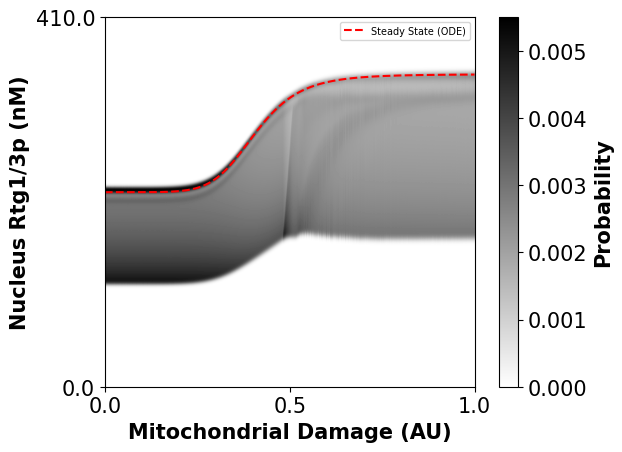

In [58]:
# output

out_ = output(solss.u, rtg13_n)

fig, ax = plt.subplots()
ax.set_xlabel("Mitochondrial Damage (AU)", fontweight="bold")
ax.set_ylabel("Nucleus Rtg1/3p (nM)", fontweight="bold")




im = ax.imshow(heatmap, cmap="binary",extent=[0,1,0,1] )

cbar = plt.colorbar(im, orientation="vertical")
cbar.ax.set_ylabel("Probability", fontweight="bold")

plotcurve!(ax, output(solss.u, rtg13_n), round(rtg3_total))
#plotcurve!(ax, output(solss2.u, rtg13_n),round(rtg3_total))




ax.yaxis.set_ticks([0, 1])
ax.xaxis.set_ticks([0, 0.5,1])
ax.set_yticklabels([0, round(rtg3_total)])




ax.legend(fontsize=7)
save(fig,"RobustAnalysis/result/Heatmap/rtg13n_1em$(-1*Int(log10(noise)))_with_steady_states.svg")
plt.display_figs()

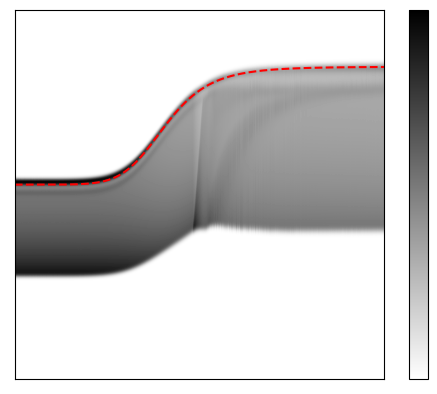

In [62]:
# output

out_ = output(solss.u, rtg13_n)

fig, ax = plt.subplots()




im = ax.imshow(heatmap, cmap="binary",extent=[0,1,0,1] )

cbar = plt.colorbar(im, orientation="vertical")
cbar.set_ticks([])
plotcurve!(ax, output(solss.u, rtg13_n), round(rtg3_total))


ax.yaxis.set_ticks([])
ax.xaxis.set_ticks([])




plt.display_figs()

fig.savefig("RobustAnalysis/result/GraphicalAbstract/rtg13n_1em$(-1*Int(log10(noise)))_with_steady_states.png", transparent=true,box_inches="tight", dpi=300)

### Plotting the probability

#### Color scale

In [2]:
y_range = 0:1:rtg3_total

out = kdes.u
len = length(out)

figp, axp = plt.subplots()

axp.plot(y_range, [pdf(out[1],i) for i in y_range], label="s=$(s[1])", linestyle="-", color="green")
axp.plot(y_range, [pdf(out[len÷3],i) for i in y_range], label="s=$(s[len÷3])", linestyle="--", color="purple")
axp.plot(y_range, [pdf(out[len÷2],i) for i in y_range], label="s=$(s[len÷2])", linestyle="--", color="purple")
axp.plot(y_range, [pdf(out[end],i) for i in y_range], label="s=$(s[end])", linestyle="dashdot", color="red")
axp.set_xlabel("Nucleus Rtg1/3p (nM)", fontweight="bold")
axp.set_ylabel("Probability", fontweight="bold")
axp.set_yticks([Int(0), 0.014])
axp.set_xticks([Int(0), 400])
axp.legend(title="Mito-Damage", loc=1, fontsize="small")
save(figp, "RobustAnalysis/result/PDF_function_Rtg13n_1em$(-1*Int(log10(noise))).svg")
save(figp, "RobustAnalysis/result/PDF_function_Rtg13n_1em$(-1*Int(log10(noise))).pdf")
plt.display_figs()

LoadError: UndefVarError: rtg3_total not defined

#### Gray Scale

In [ ]:
y_range = 0:1:rtg3_total

out = kdes.u
len = length(out)

T = 0:0.01:1
grays = range(0, 0.8, length=length(T))

figp, axp = plt.subplots()

# Plot gradient curves
Folds.map(j-> 
    begin
    i_s = T[j] == 1 ? length(out) : trunc(Int,T[j] * length(out) ) + 1
    axp.plot(y_range, [pdf(out[i_s],i) for i in y_range], label="s=$(s[1])", linestyle="-", color="$(grays[j])" ,lw=2, alpha=0.6);
    end,
    (j for j in eachindex(T)));



axp.set_xlabel("Nucleus Rtg1/3p (nM)", fontweight="bold")
axp.set_ylabel("Probability", fontweight="bold")
axp.set_yticks([Int(0), 0.014])
axp.set_xticks([Int(0), 400])

save(figp, "RobustAnalysis/result/PDE_function_Rtg13n_$(length(len))_lines_1em$(-1*Int(log10(noise))).svg")
save(figp, "RobustAnalysis/result/PDE_function_Rtg13n_$(length(len))_lines_1em$(-1*Int(log10(noise))).pdf")